# Lab 1. NER (Makarov, Shabalin), dataset: https://huggingface.co/datasets/mnaguib/WikiNER

# Загрузка данных и EDA

Загрузим библиотеки и датасет. Работать будем с русскоязычным разделом.

In [ ]:
from datasets import load_dataset
import random
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
!pip install seqeval -q
from seqeval.metrics import classification_report
from tqdm import tqdm
import time
!pip install pytorch-crf
from torchcrf import CRF
import warnings
warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
wikiner_ru = load_dataset('mnaguib/WikiNER', 'ru')
print(wikiner_ru)

README.md: 0.00B [00:00, ?B/s]

data/ru/train.parquet:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

data/ru/test.parquet:   0%|          | 0.00/2.27M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/161238 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/17912 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'ner_tags'],
        num_rows: 161238
    })
    test: Dataset({
        features: ['id', 'words', 'ner_tags'],
        num_rows: 17912
    })
})


На странице датасета на Hugging Face указана следующая схема разметки: {0: 'O', 1: 'LOC', 2: 'PER', 3: 'MISC', 4: 'ORG'}. Создадим словари для удобного преобразования тегов.

In [ ]:
id2tag = {
    0: 'O',
    1: 'LOC',
    2: 'PER',
    3: 'MISC',
    4: 'ORG'
}

tag2id = {tag: i for i, tag in id2tag.items()}
num_tags = len(id2tag)

print("Схема разметки (id -> тег):", id2tag)
print("Количество уникальных тегов:", num_tags)

Схема разметки (id -> тег): {0: 'O', 1: 'LOC', 2: 'PER', 3: 'MISC', 4: 'ORG'}
Количество уникальных тегов: 5


Посмотрим на данные. Найдём первый пример, содержащий именованные сущности и посмотрим на его разметку.

In [ ]:
found_example = None
example_index = -1

for i, example in enumerate(wikiner_ru['train']):
    if any(tag != 0 for tag in example['ner_tags']):
        found_example = example
        example_index = i
        break

if found_example:
    print(f"Пример с сущностями найден под индексом: {example_index}")


    words = found_example['words']
    tags = found_example['ner_tags']
    decoded_tags = [id2tag[tag_id] for tag_id in tags]

    print("\nРасшифрованные теги для найденного примера")
    for word, tag in zip(words, decoded_tags):
        print(f"{word:<20} {tag}")

Пример с сущностями найден под индексом: 2

Расшифрованные теги для найденного примера
Город                O
расположен           O
в                    O
234                  O
км                   O
от                   O
г.                   O
Ставрополь           LOC
,                    O
в                    O
северных             O
предгорьях           O
Большого             LOC
Кавказа              LOC
на                   O
высоте               O
800                  O
--                   O
1069                 O
м                    O
над                  O
уровнем              O
моря                 O
.                    O


Видим, что данные размечены по простой схеме без IOB-префиксов (например, B-LOC, I-LOC). Пример с индексом 2, содержащий слова "Ставрополь" и "Большой Кавказ", корректно размечен тегами LOC и LOC LOC соответственно. Это подтверждает правильность нашей интерпретации схемы тегов. Качество данных на первый взгляд является удовлетворительным.

Однако эта "простая" схема имеет свои недостатки: невозможно различить две идущие подряд сущности одного типа. Например, в предложении "Встреча Россия США" разметка будет ORG ORG, и мы не сможем программно понять, одна это сущность ("Россия США") или две разные ("Россия" и "США"). Для данного датасета мы принимаем это как ограничение.

Посмотрим на реальный пример. Выведем несколько предложений и подсветим в них именованные сущности.

In [ ]:
def visualize_ner(words, tags, id2tag_map):
    html = ""
    color_map = {
        'PER': '#FFADAD',
        'LOC': '#A0C4FF',
        'ORG': '#BDB2FF',
    }

    for word, tag_id in zip(words, tags):
        tag = id2tag_map.get(tag_id, 'O')
        if tag != 'O':
            html += f"<span style='background-color:{color_map[tag]}; border-radius: 4px; padding: 2px; margin:1px'><b>{word}</b> <sub style='font-size: 0.7em;'>{tag}</sub></span> "
        else:
            html += f"{word} "
    display(HTML(html))

for i in [2, 100, 545, 1024]:
    example = wikiner_ru['train'][i]
    visualize_ner(example['words'], example['ner_tags'], id2tag)

Ранее сделанные наблюдения подтверждаются. Мы видим, что "Большой Кавказ" размечен как LOC LOC. В целом, разметка выглядит адекватной и логичной.

Проанализируем, насколько сбалансированы классы в нашем датасете. Это важно, так как сильный дисбаланс (что типично для NER, где тег 'O' доминирует) может повлиять на обучение модели и выбор метрик.

Распределение тегов в обучающей выборке:
O: 2534053 (89.32%)
LOC: 139570 (4.92%)
PER: 109978 (3.88%)
ORG: 53543 (1.89%)


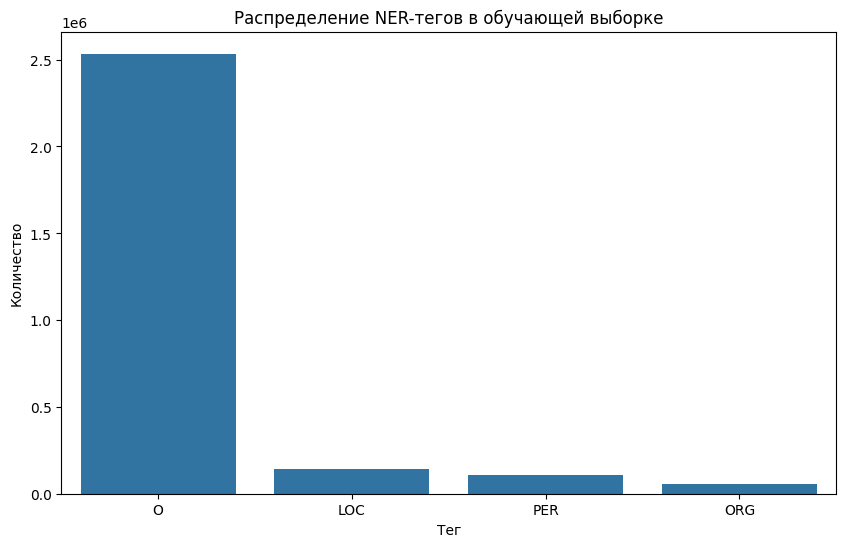

In [ ]:
all_tags = [tag_id for example in wikiner_ru['train'] for tag_id in example['ner_tags']]


tag_counts = Counter(all_tags)


decoded_tag_counts = {id2tag[tag_id]: count for tag_id, count in tag_counts.items()}


sorted_tag_counts = dict(sorted(decoded_tag_counts.items(), key=lambda item: item[1], reverse=True))

print("Распределение тегов в обучающей выборке:")
for tag, count in sorted_tag_counts.items():
    print(f"{tag}: {count} ({(count / len(all_tags)) * 100:.2f}%)")


plt.figure(figsize=(10, 6))
sns.barplot(x=list(sorted_tag_counts.keys()), y=list(sorted_tag_counts.values()))
plt.title('Распределение NER-тегов в обучающей выборке')
plt.xlabel('Тег')
plt.ylabel('Количество')
plt.show()

Как и ожидалось, наблюдается сильный дисбаланс классов. Тег O (не сущность) составляет подавляющее большинство (около 89%). Среди именованных сущностей чаще всего встречаются LOC (локации), а реже всего ORG (организации). Сущность MISC (разное) вообще не встречается в данных.


Простая accuracy будет бесполезна. Модель, которая всегда предсказывает 'O', будет иметь точность ~89%, но при этом будет абсолютно бесполезной. Нам нужны метрики, которые учитывают дисбаланс, такие как F1-score, Precision и Recall, рассчитанные для каждого класса сущностей. Модель может "лениться" и предпочитать предсказывать доминирующий класс 'O'. С этим можно будет бороться в дальнейшем, например, с помощью взвешивания классов в функции потерь, но для базовой модели сделаем без этого.

Посмотрим на распределение длин предложений. Это поможет нам определить оптимальную длину последовательности для паддинга (дополнения) и возможного усечения.

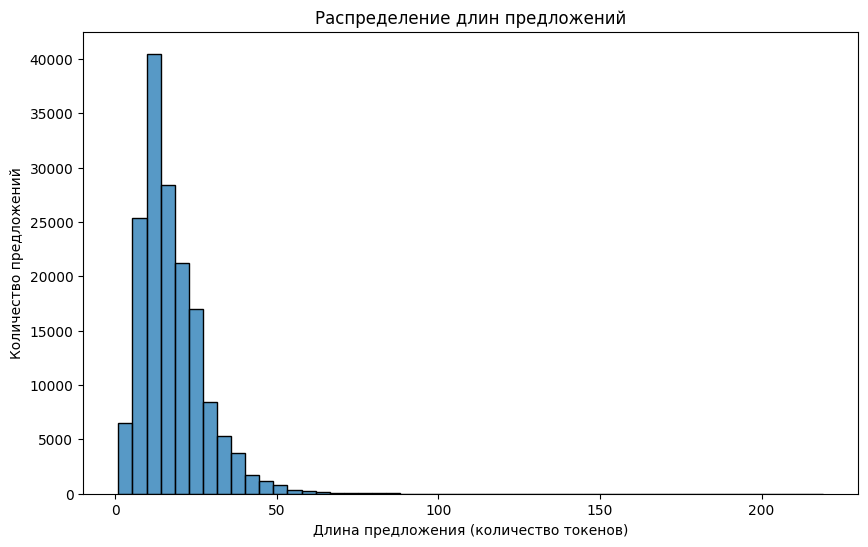

Минимальная длина предложения: 1
Максимальная длина предложения: 219
Средняя длина предложения: 17.60
95-й перцентиль длины: 36.00


In [ ]:
sentence_lengths = [len(example['words']) for example in wikiner_ru['train']]

plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, bins=50)
plt.title('Распределение длин предложений')
plt.xlabel('Длина предложения (количество токенов)')
plt.ylabel('Количество предложений')
plt.show()

print(f"Минимальная длина предложения: {np.min(sentence_lengths)}")
print(f"Максимальная длина предложения: {np.max(sentence_lengths)}")
print(f"Средняя длина предложения: {np.mean(sentence_lengths):.2f}")
print(f"95-й перцентиль длины: {np.percentile(sentence_lengths, 95):.2f}")

График наглядно показывает, что подавляющее большинство предложений имеют небольшую длину, с пиком в районе 10-20 токенов. При этом есть очень длинные "выбросы", достигающие 219 токенов. Видно, что 95% всех предложений в обучающей выборке короче 36 токенов.

Установим максимальную длину предложения 40, чтобы ускорить обучение. Это значение немного выше 95-го перцентиля, что является хорошим компромиссом. Предложения короче этой длины будут дополнены специальным <PAD> токеном до длины 40. Предложения длиннее 40 токенов будут обрезаны. Это затронет менее 5% данных и позволит нам значительно повысить эффективность обучения.

In [ ]:
test_tags_unique = set()
for example in wikiner_ru['test']:
    for tag_id in example['ner_tags']:
        test_tags_unique.add(tag_id)

misc_id = 3
if misc_id not in test_tags_unique:
    print(f"Тега MISC в тестовой выборке нет.")

print(f"Уникальные ID тегов в тестовом наборе: {sorted(list(test_tags_unique))}")

Тега MISC в тестовой выборке нет.
Уникальные ID тегов в тестовом наборе: [0, 1, 2, 4]



На странице датасета на Hugging Face указана схема разметки, включающая тег 'MISC'. Однако, как показал наш анализ (см. график распределения тегов), в обучающей выборке этого тега нет. Проверив тестовый набор, мы убедились, что и там он отсутствует. Чтобы сделать модель более эффективной и не обучать её на несуществующем классе,
мы исключим 'MISC' из нашей схемы тегов.

In [ ]:
id2tag = {
    0: 'O',
    1: 'LOC',
    2: 'PER',
    3: 'ORG'
}

tag2id = {tag: i for i, tag in id2tag.items()}
num_tags = len(id2tag)

print("Скорректированная схема разметки (id -> тег):", id2tag)
print("Новое количество уникальных тегов:", num_tags)

remap_tags_dict = {0: 0, 1: 1, 2: 2, 4: 3}

Скорректированная схема разметки (id -> тег): {0: 'O', 1: 'LOC', 2: 'PER', 3: 'ORG'}
Новое количество уникальных тегов: 4


Давайте посмотрим, какие именно сущности чаще всего встречаются в обучающей выборке. Это поможет нам понять специфику датасета (он основан на Википедии, поэтому можно ожидать много географических названий, имен исторических личностей и названий организаций) и заранее предположить, на каких примерах модель будет обучаться лучше всего.

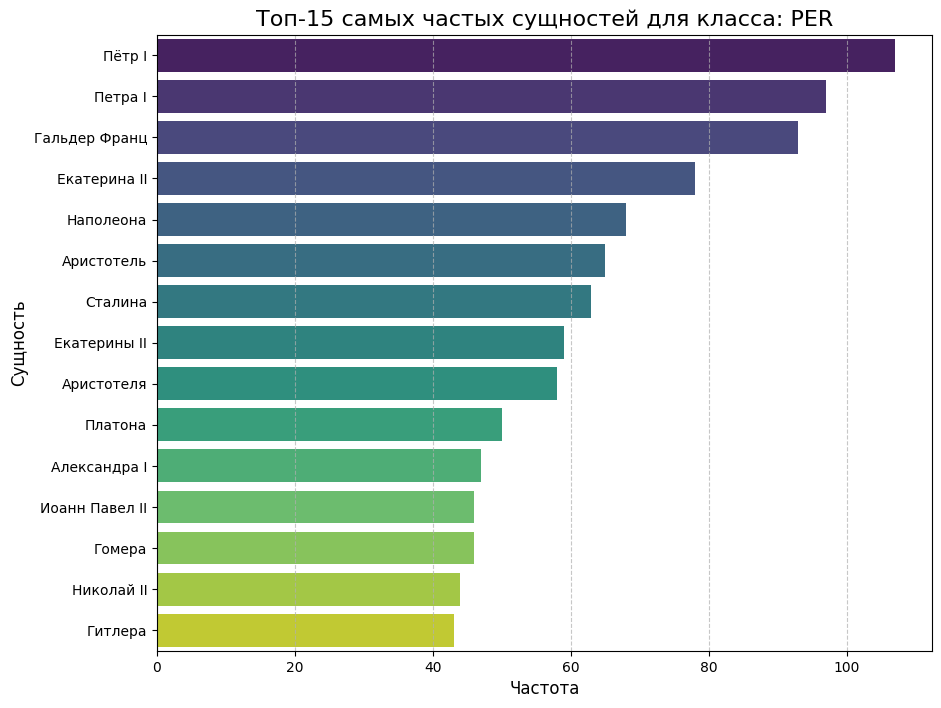

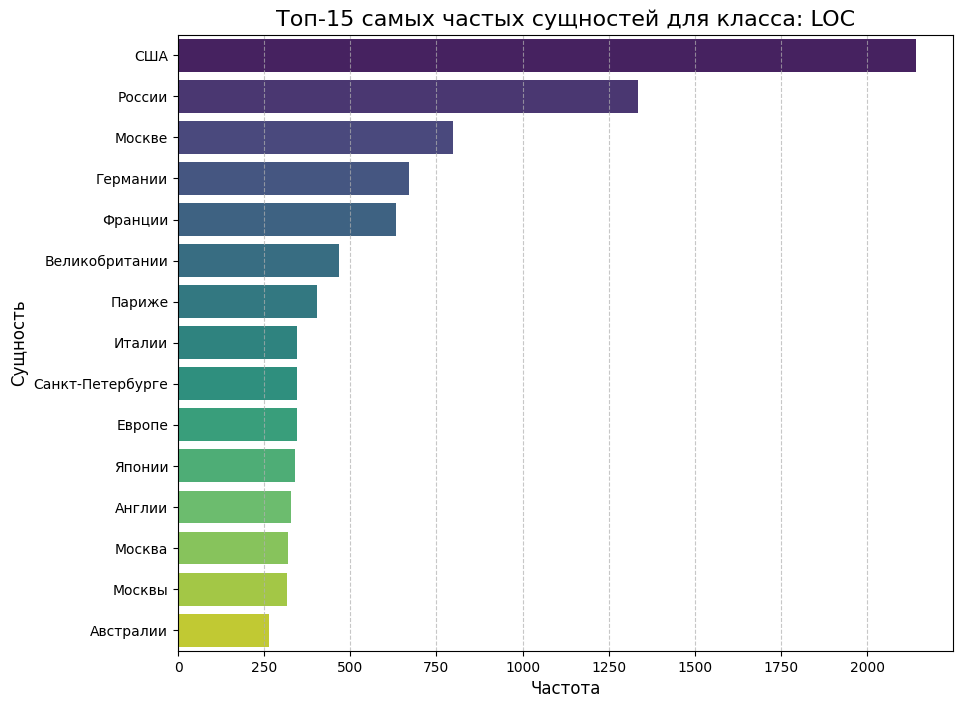

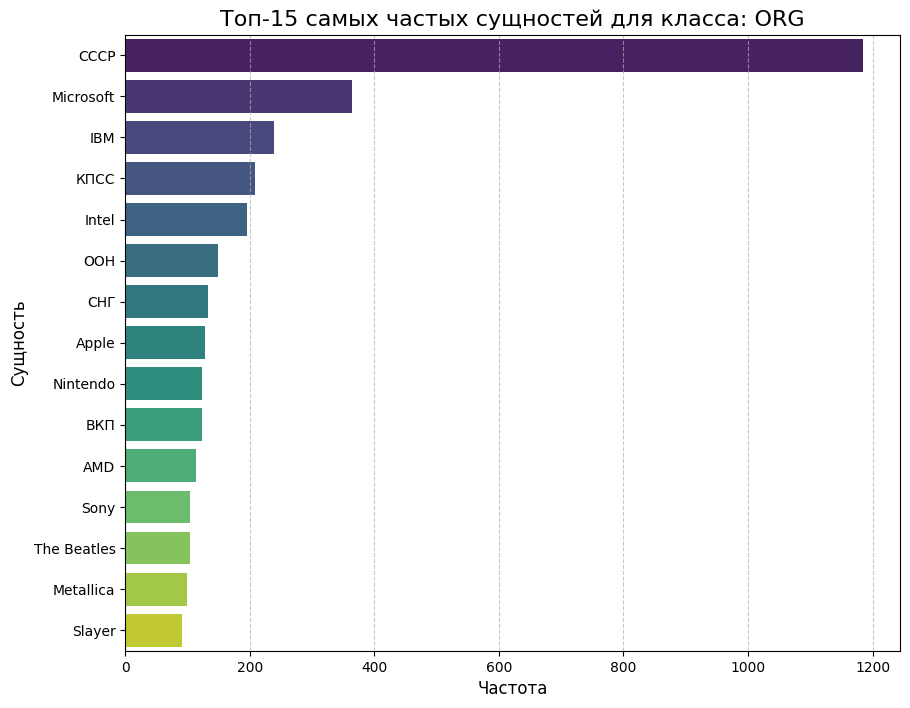

In [ ]:
entities = {
    'PER': Counter(),
    'LOC': Counter(),
    'ORG': Counter()
}

original_id2tag = {
    0: 'O', 1: 'LOC', 2: 'PER', 3: 'MISC', 4: 'ORG'
}


for example in wikiner_ru['train']:
    words = example['words']
    tags = [original_id2tag.get(tag_id, 'O') for tag_id in example['ner_tags']]

    current_entity_words = []
    current_entity_tag = None

    for word, tag in zip(words + ['DUMMY'], tags + ['O']):
        simple_tag = tag.split('-')[-1]

        if simple_tag in entities:
            if current_entity_tag is None:
                current_entity_tag = simple_tag
                current_entity_words.append(word)
            elif current_entity_tag == simple_tag:
                current_entity_words.append(word)
            else:
                if current_entity_words:
                    entities[current_entity_tag][' '.join(current_entity_words)] += 1
                current_entity_tag = simple_tag
                current_entity_words = [word]
        else:
            if current_entity_words:
                entities[current_entity_tag][' '.join(current_entity_words)] += 1
            current_entity_words = []
            current_entity_tag = None

N_TOP = 15

for tag, counter in entities.items():
    most_common_df = pd.DataFrame(counter.most_common(N_TOP), columns=['Сущность', 'Частота'])

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Частота', y='Сущность', data=most_common_df, palette='viridis')
    plt.title(f'Топ-{N_TOP} самых частых сущностей для класса: {tag}', fontsize=16)
    plt.xlabel('Частота', fontsize=12)
    plt.ylabel('Сущность', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

*   **LOC (Локации):** В топе предсказуемо находятся названия стран (**США**, **России**), городов (**Москва**) и континентов/частей света (**Европа**). Это очень частые и, в большинстве случаев, однозначные сущности. Ожидается, что модель научится их определять без особого труда.

*   **PER (Персоны):** Здесь мы видим имена исторических личностей и правителей (**Петр I**, **Екатерина II**, **Наполеон**). Интересно, что в топе есть как полные имена, так и имена с номерами. Это говорит о том, что модели нужно будет научиться работать с разными форматами имен и распознавать их как единую сущность.

*   **ORG (Организации):** Самой частой сущностью с большим отрывом является **"СССР"**. Это подсвечивает важную проблему и особенность NER — зависимость от контекста. В данном датасете "СССР" чаще всего размечался как организация, а не как географическая территория. Также в топе присутствуют названия крупных технологических компаний (Microsoft, IBM, Intel, Apple) и политических партий (КПСС). Модели необходимо будет научиться на основе контекста различать, когда название страны является локацией а когда — организацией.


Помимо самих сущностей, полезно посмотреть на их длину в токенах. Состоят ли они в основном из одного слова или из нескольких? Это влияет на сложность задачи. Модели LSTM хорошо справляются с запоминанием контекста, что важно для многословных сущностей.

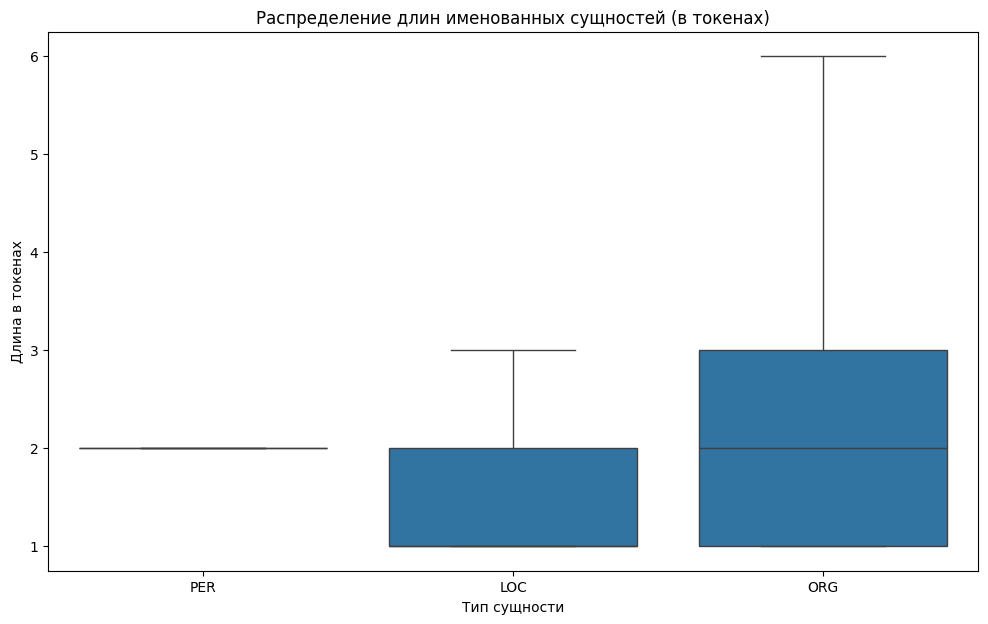

Средняя длина сущности по типам:
Tag
LOC    1.63
ORG    2.20
PER    1.99
Name: Length, dtype: float64


In [ ]:
entity_lengths = []
for tag, counter in entities.items():
    for entity, count in counter.items():
        entity_lengths.append((tag, len(entity.split()), count))

df_lengths = pd.DataFrame(entity_lengths, columns=['Tag', 'Length', 'Count'])

plt.figure(figsize=(12, 7))
sns.boxplot(x='Tag', y='Length', data=df_lengths, showfliers=False)
plt.title('Распределение длин именованных сущностей (в токенах)')
plt.xlabel('Тип сущности')
plt.ylabel('Длина в токенах')
plt.show()

print("Средняя длина сущности по типам:")
print(df_lengths.groupby('Tag')['Length'].mean().round(2))

График показывает, что медианная длина всех типов сущностей составляет 1-2 токена. Однако у класса ORG наблюдается наибольший разброс в длине, что говорит о наличии как коротких , так и длинных названий организаций. Это подтверждает, что использование двунаправленной LSTM является хорошим выбором, так как она способна захватывать зависимости между словами в рамках одной многословной сущности.

Анализ словаря на предмет "шума"

Прежде чем строить итоговый словарь, давайте посмотрим на "сырые" токены, чтобы оценить их качество. Нас интересуют две вещи:
1.  **Количество очень редких слов:** Большое количество слов, которые встречаются 1-2 раза, часто указывает на опечатки, уникальные идентификаторы или просто очень специфичные термины, которые модель не сможет выучить.
2.  **Наличие "мусорных" токенов:** Токены, состоящие из пунктуации, или слова, "склеенные" со знаками препинания.

In [ ]:
raw_word_counts = Counter(word.lower() for sentence in wikiner_ru['train']['words'] for word in sentence)

print(f"Общее количество уникальных токенов в сырых данных: {len(raw_word_counts)}")

single_occurrence_words = sum(1 for count in raw_word_counts.values() if count == 1)
print(f"Количество токенов, которые встречаются только 1 раз: {single_occurrence_words} ({(single_occurrence_words / len(raw_word_counts)) * 100:.2f}%)")

print("\nПримеры самых редких токенов:")
print(raw_word_counts.most_common()[-10:])

print("\nПримеры 'мусорных' токенов:")
garbage_examples = []
allowed_chars_re_check = re.compile(r"^[a-zа-яё-]+$")
for word, count in raw_word_counts.most_common():
    if not allowed_chars_re_check.match(word) and not word.isnumeric():
        garbage_examples.append(word)
    if len(garbage_examples) >= 10:
        break
print(garbage_examples)

Общее количество уникальных токенов в сырых данных: 218477
Количество токенов, которые встречаются только 1 раз: 113040 (51.74%)

Примеры самых редких токенов:
[('сатанисткую', 1), ('уиннипесоки', 1), ('toxic', 1), ('програть', 1), ('радиодоступа', 1), ('гроссмейстеры', 1), ('гидеон', 1), ('бирюзовый', 1), ('материкам', 1), ('интродуцированной', 1)]

Примеры 'мусорных' токенов:
[',', '.', '"', ')', '(', ':', 'г.', ';', 'а.', '%']


*   Более половины (51.74%) всех уникальных токенов встречаются в тексте всего один раз! Обучать модель на таких данных бессмысленно — она не сможет сделать никаких обобщений и просто "запомнит" эти слова, что ведет к переобучению. Это доказывает необходимость частотной фильтрации.
*   Мы видим множество "мусорных" токенов, которые не являются словами, но были выделены при токенизации датасета. Это доказывает необходимость фильтрации по символьному составу.
*   Также мы обобщим числа до одного токена `<NUM>`.


Резюмируем.
Проведенный анализ даёт следующие выводы:

Сильный дисбаланс классов: Подавляющее большинство токенов (~89%) относится к классу 'O'. Это значит, что метрика accuracy будет бесполезна. Мы должны сфокусироваться на F1-score, Precision и Recall для каждого класса и на их усредненных значениях.

Структура сущностей: Сущности в основном короткие (1-2 слова), но встречаются и более длинные. Схема разметки простая (без IOB). Это делает Bi-LSTM хорошим кандидатом, так как она может улавливать зависимости внутри многословных сущностей. Логичным следующим шагом для учета структурных зависимостей между тегами выглядит добавление CRF-слоя.

Разнообразие и контекст: Датасет содержит разнообразные сущности, и их тип часто зависит от контекста (например, "Россия" как LOC или ORG). Это требование к модели быть достаточно мощной, чтобы улавливать контекстные подсказки. Архитектуры на основе RNN (как LSTM) и тем более трансформеры (BERT) хорошо для этого подходят. Но трансформеры использовать в работе не будем, оставим это на следующие работы.

Длина предложений: Большинство предложений относительно короткие (95% короче 36 токенов). Выбранное значение MAX_LEN = 40 является разумным компромиссом, который позволит охватить почти все данные, не создавая излишней вычислительной нагрузки из-за паддинга.

# Предобработка данных

Как показал предыдущий анализ словаря, он содержит огромное количество редких и "мусорных" токенов. Нужно сделать модель более устойчивой к переобучению и уменьшить размерность данных.

Проведем очистку и нормализацию данных со следующими шагами:
1.  **Нормализация чисел:** Заменим все числа на специальный токен `<NUM>`.
2.  **Фильтрация токенов:** Оставим только токены, состоящие из букв, дефисов и нашего спецтокена `<NUM>`.
3.  **Частотный порог:** Посчитаем частоту встречаемости каждого слова и добавим в итоговый словарь только те, которые встретились 3 или более раз. Остальные будут заменены на `<UNK>`.

In [ ]:
word_counts = Counter()
for sentence in wikiner_ru['train']['words']:
    for word in sentence:
        word = word.lower()
        word = re.sub(r'\d+', '<NUM>', word)
        word_counts[word] += 1

print(f"Количество уникальных токенов до фильтрации: {len(word_counts)}")


MIN_FREQ = 3
word2id = {'<PAD>': 0, '<UNK>': 1, '<NUM>': 2}
current_id = 3


allowed_chars_re = re.compile(r"^[a-zа-яё-]+$")

for word, count in word_counts.items():
    if count >= MIN_FREQ:

        if allowed_chars_re.match(word) or word == '<NUM>':
            if word not in word2id:
                word2id[word] = current_id
                current_id += 1

id2word = {i: word for word, i in word2id.items()}
vocab_size = len(word2id)

print(f"Размер итогового словаря (слова с частотой >= {MIN_FREQ}): {vocab_size}")


example_word = 'ставрополь'
print(f"ID для слова '{example_word}': {word2id.get(example_word, word2id['<UNK>'])}")

example_num = '234'
processed_num = re.sub(r'\d+', '<NUM>', example_num.lower())
print(f"ID для числа '{example_num}': {word2id.get(processed_num, word2id['<UNK>'])}")


example_rare = ',-учение,разработанное'
print(f"ID для мусорного токена '{example_rare}': {word2id.get(example_rare, word2id['<UNK>'])}")

Количество уникальных токенов до фильтрации: 208773
Размер итогового словаря (слова с частотой >= 3): 68771
ID для слова 'ставрополь': 29
ID для числа '234': 2
ID для мусорного токена ',-учение,разработанное': 1


Токенизация в нашем случае не требуется, так как датасет токенизирован. Сделаем преобразование в ID и паддинг.

Для паддинга тегов используется значение -100. Это стандартная практика, так как функция потерь в PyTorch по умолчанию игнорирует этот индекс и не учитывает его при расчете ошибки, что позволяет нам работать с последовательностями разной длины в одном батче.


In [ ]:
MAX_LEN = 40

def tokenize_and_pad(examples):
    processed_words_lists = [
        [re.sub(r'\d+', '<NUM>', word.lower()) for word in words_list]
        for words_list in examples['words']
    ]

    token_ids = [
        [word2id.get(word, word2id['<UNK>']) for word in words_list]
        for words_list in processed_words_lists
    ]

    padded_token_ids = [
        seq[:MAX_LEN] + [word2id['<PAD>']] * max(0, MAX_LEN - len(seq))
        for seq in token_ids
    ]

    padded_tag_ids = [
      [remap_tags_dict.get(tag_id) for tag_id in seq[:MAX_LEN]] + [-100] * max(0, MAX_LEN - len(seq))
      for seq in examples['ner_tags']
    ]

    return {'input_ids': padded_token_ids, 'labels': padded_tag_ids}


processed_wikiner = wikiner_ru.map(tokenize_and_pad, batched=True)

print("Пример обработки:")
original_words = processed_wikiner['train'][2]['words']
print("Оригинальные слова:", original_words)
print("ID слов (до MAX_LEN):", processed_wikiner['train'][2]['input_ids'][:len(original_words)])
print("ID тегов (до MAX_LEN):", processed_wikiner['train'][2]['labels'][:len(original_words)])

Map:   0%|          | 0/161238 [00:00<?, ? examples/s]

Map:   0%|          | 0/17912 [00:00<?, ? examples/s]

Пример обработки:
Оригинальные слова: ['Город', 'расположен', 'в', '234', 'км', 'от', 'г.', 'Ставрополь', ',', 'в', 'северных', 'предгорьях', 'Большого', 'Кавказа', 'на', 'высоте', '800', '--', '1069', 'м', 'над', 'уровнем', 'моря', '.']
ID слов (до MAX_LEN): [25, 26, 16, 2, 27, 28, 1, 29, 1, 16, 30, 31, 32, 33, 34, 35, 2, 5, 2, 36, 37, 38, 39, 1]
ID тегов (до MAX_LEN): [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Обучение моделей

Теперь проведём два эксперимента с LSTM.


Эксперимент 1 (Baseline): Модель на основе двунаправленной LSTM (Bi-LSTM). Это будет нашей отправной точкой.

Эксперимент 2 (Улучшение): Bi-LSTM + слой CRF (Conditional Random Field). Это улучшение, которое добавляет логику в последовательность предсказанных тегов.

Эксперимент 1: Модель Bi-LSTM

Наша базовая модель имеет следующую архитектуру, состоящую из трех ключевых слоев:

*   **Слой `nn.Embedding`:** Преобразует входные ID токенов в плотные векторные представления (эмбеддинги) фиксированной размерности (`embedding_dim`). В процессе обучения слой выучивает семантически близкие представления для схожих по контексту слов.

*   **Слой `nn.LSTM` с `bidirectional=True`:** Обрабатывает последовательность эмбеддингов в двух направлениях: прямом (от начала к концу) и обратном. Это позволяет модели для каждого токена формировать контекстно-зависимое представление, учитывающее как предыдущие, так и последующие слова, что особенно важно для распознавания многословных сущностей.

*   **Полносвязный слой `nn.Linear`:** Принимает скрытое состояние от Bi-LSTM для каждого токена и проецирует его на пространство размером в количество наших NER-тегов (`num_tags`). В результате для каждого слова генерируются логиты, которые используются для предсказания наиболее вероятного тега.

In [ ]:
train_inputs = torch.tensor(processed_wikiner['train']['input_ids'])
train_labels = torch.tensor(processed_wikiner['train']['labels'])
test_inputs = torch.tensor(processed_wikiner['test']['input_ids'])
test_labels = torch.tensor(processed_wikiner['test']['labels'])

train_dataset = TensorDataset(train_inputs, train_labels)
test_dataset = TensorDataset(test_inputs, test_labels)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


class BiLSTM_NER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_tags):

        super(BiLSTM_NER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word2id['<PAD>'])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_tags)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        logits = self.fc(lstm_out)

        return logits


EMBEDDING_DIM = 100
HIDDEN_DIM = 128
model = BiLSTM_NER(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, num_tags)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)

BiLSTM_NER(
  (embedding): Embedding(68771, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
)


*   **Функция потерь:** В качестве функции потерь используется `nn.CrossEntropyLoss`. Параметр `ignore_index=-100` обеспечивает корректную обработку паддинг-токенов — они не учитываются при вычислении градиентов.

*   **Оптимизатор:** Для оптимизации весов модели выбран алгоритм `Adam` со стандартной скоростью обучения `0.001`.

*   **Метрики качества:** Учитывая сильный дисбаланс классов, выявленный в ходе EDA, для оценки качества модели используются стандартные для NER-задач метрики: **Precision, Recall и F1-score**. Расчет метрик производится с помощью библиотеки `seqeval`, которая корректно оценивает качество на уровне целых именованных сущностей.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for inputs, labels in tqdm(data_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, num_tags), labels.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

def to_iob(tags_list, id2tag_map):
    iob_tags = []
    for i, tag_id in enumerate(tags_list):
        tag = id2tag_map[tag_id]
        if tag == 'O':
            iob_tags.append('O')
        elif i == 0 or id2tag_map[tags_list[i-1]] != tag:
            iob_tags.append('B-' + tag)
        else:
            iob_tags.append('I-' + tag)
    return iob_tags


def evaluate(model, data_loader, device, id2tag_map):
    model.eval()
    all_preds_iob = []
    all_true_iob = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=2)

            for i in range(labels.shape[0]):
                true_tags_ids = [label_id.item() for label_id in labels[i] if label_id != -100]
                pred_tags_ids = [pred_id.item() for pred_id, label_id in zip(preds[i], labels[i]) if label_id != -100]

                all_true_iob.append(to_iob(true_tags_ids, id2tag_map))
                all_preds_iob.append(to_iob(pred_tags_ids, id2tag_map))

    return classification_report(all_true_iob, all_preds_iob, output_dict=True, zero_division=0)

Эксперимент 1: обучение.

In [ ]:
NUM_EPOCHS = 3


for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    avg_train_loss = train_epoch(model, train_loader, criterion, optimizer, device)

    report = evaluate(model, test_loader, device, id2tag)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    print(f'\nЭпоха: {epoch+1:02} | Время: {int(epoch_mins)}m {int(epoch_secs)}s')
    print(f'\tСредняя потеря на обучении: {avg_train_loss:.3f}')
    print("\tРезультаты на тестовой выборке:")


    entity_types = ['PER', 'LOC', 'ORG']


    for tag in entity_types:
        if tag in report:
            metrics = report[tag]
            print(f"\t\t{tag:<10} - "
                  f"Precision: {metrics['precision']:.4f} | "
                  f"Recall: {metrics['recall']:.4f} | "
                  f"F1-score: {metrics['f1-score']:.4f}")

    if 'weighted avg' in report:
        weighted_avg = report['weighted avg']
        print(f"\t\t{'Overall (Weighted)':<18} - "
              f"Precision: {weighted_avg['precision']:.4f} | "
              f"Recall: {weighted_avg['recall']:.4f} | "
              f"F1-score: {weighted_avg['f1-score']:.4f}")

    if 'accuracy' in report:
        print(f"\t\t{'Accuracy':<18} - {report['accuracy']:.4f}")

Evaluating: 100%|██████████| 560/560 [00:26<00:00, 21.32it/s]



Эпоха: 01 | Время: 16m 6s
	Средняя потеря на обучении: 0.210
	Результаты на тестовой выборке:
		PER        - Precision: 0.5731 | Recall: 0.4936 | F1-score: 0.5304
		LOC        - Precision: 0.7773 | Recall: 0.6889 | F1-score: 0.7304
		ORG        - Precision: 0.5911 | Recall: 0.4359 | F1-score: 0.5018
		Overall (Weighted) - Precision: 0.6861 | Recall: 0.5894 | F1-score: 0.6335


Evaluating: 100%|██████████| 560/560 [00:26<00:00, 21.38it/s]



Эпоха: 02 | Время: 16m 35s
	Средняя потеря на обучении: 0.103
	Результаты на тестовой выборке:
		PER        - Precision: 0.6566 | Recall: 0.5962 | F1-score: 0.6250
		LOC        - Precision: 0.8108 | Recall: 0.7575 | F1-score: 0.7832
		ORG        - Precision: 0.6615 | Recall: 0.5492 | F1-score: 0.6002
		Overall (Weighted) - Precision: 0.7405 | Recall: 0.6754 | F1-score: 0.7062


Evaluating: 100%|██████████| 560/560 [00:27<00:00, 20.51it/s]



Эпоха: 03 | Время: 16m 47s
	Средняя потеря на обучении: 0.071
	Результаты на тестовой выборке:
		PER        - Precision: 0.6940 | Recall: 0.6321 | F1-score: 0.6616
		LOC        - Precision: 0.8238 | Recall: 0.7776 | F1-score: 0.8000
		ORG        - Precision: 0.6862 | Recall: 0.6009 | F1-score: 0.6407
		Overall (Weighted) - Precision: 0.7627 | Recall: 0.7054 | F1-score: 0.7328


**Результат:** Модель Bi-LSTM показала базовое качество в задаче NER. Как показал анализ, класс `LOC` распознается лучше всего, в то время как `ORG` — сложнее, что логично, так как названия организаций более разнообразны и контекстно-зависимы.

**Недостатки** Главный недостаток этой архитектуры — **независимость решений**. Модель предсказывает тег для каждого слова отдельно. Это может приводить к логически неверным последовательностям тегов.

**Улучшение:** Чтобы исправить это, нужно добавить слой, который учитывает зависимости между предсказанными тегами. Идеальным кандидатом на эту роль является **CRF (Conditional Random Field)**.

Эксперимент 2: Модель Bi-LSTM + CRF

Для улучшения базовой модели мы добавляем слой **CRF** поверх Bi-LSTM. Архитектура теперь состоит из следующих компонентов:

*   **Слои `nn.Embedding` и `nn.LSTM`:** Работают так же, как и в базовой модели, генерируя контекстно-зависимые логиты для каждого токена.

*   **Слой `CRF`:** Этот слой является ключевым улучшением. Он работает не с отдельными токенами, а со всей последовательностью целиком. В процессе обучения `CRF`-слой выучивает матрицу вероятностей переходов между тегами.

Во время предсказания (инференса) `CRF`-слой использует эти выученные правила, чтобы найти не просто наиболее вероятный тег для каждого слова, а наиболее вероятную последовательность тегов для всего предложения.

In [ ]:
class BiLSTM_CRF_NER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_tags):
        super(BiLSTM_CRF_NER, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=word2id['<PAD>'])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_tags)
        self.crf = CRF(num_tags, batch_first=True)

    def forward(self, x, tags=None):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        logits = self.fc(lstm_out)
        mask = (x != word2id['<PAD>'])

        if tags is not None:
            loss = -self.crf(logits, tags, mask=mask, reduction='mean')
            return loss
        else:
            decoded_tags = self.crf.decode(logits, mask=mask)
            return decoded_tags

model_crf = BiLSTM_CRF_NER(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, num_tags)
model_crf.to(device)
optimizer_crf = torch.optim.Adam(model_crf.parameters(), lr=0.001)

print(model_crf)

BiLSTM_CRF_NER(
  (embedding): Embedding(68771, 100, padding_idx=0)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
  (crf): CRF(num_tags=4)
)


In [ ]:
def train_epoch_crf(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0

    for inputs, labels in tqdm(data_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        labels[labels == -100] = tag2id['O']

        loss = model(inputs, tags=labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)


def evaluate_crf(model, data_loader, device, id2tag_map):
    model.eval()
    all_preds_iob = []
    all_true_iob = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            predicted_tag_ids_list = model(inputs)

            for i in range(labels.shape[0]):
                true_tags_ids = [label_id.item() for label_id in labels[i] if label_id != -100]

                pred_tags_ids = predicted_tag_ids_list[i]
                all_true_iob.append(to_iob(true_tags_ids, id2tag_map))
                all_preds_iob.append(to_iob(pred_tags_ids, id2tag_map))

    return classification_report(all_true_iob, all_preds_iob, output_dict=True, zero_division=0)

history = {}
history['Bi-LSTM'] = evaluate(model, test_loader, device, id2tag)


for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    avg_train_loss = train_epoch_crf(model_crf, train_loader, optimizer_crf, device)
    report_crf = evaluate_crf(model_crf, test_loader, device, id2tag)

    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    print(f'\nЭпоха: {epoch+1:02} | Время: {int(epoch_mins)}m {int(epoch_secs)}s')
    print(f'\tСредняя потеря на обучении: {avg_train_loss:.3f}')
    print("\tРезультаты на тестовой выборке (Bi-LSTM + CRF):")

    entity_types = ['PER', 'LOC', 'ORG']
    for tag in entity_types:
        if tag in report_crf:
            metrics = report_crf[tag]
            print(f"\t\t{tag:<10} - "
                  f"Precision: {metrics['precision']:.4f} | "
                  f"Recall: {metrics['recall']:.4f} | "
                  f"F1-score: {metrics['f1-score']:.4f}")

    if 'weighted avg' in report_crf:
        weighted_avg = report_crf['weighted avg']
        print(f"\t\t{'Overall (Weighted)':<18} - "
              f"Precision: {weighted_avg['precision']:.4f} | "
              f"Recall: {weighted_avg['recall']:.4f} | "
              f"F1-score: {weighted_avg['f1-score']:.4f}")

history['Bi-LSTM + CRF'] = report_crf

Evaluating: 100%|██████████| 560/560 [00:23<00:00, 23.39it/s]



Эпоха: 01 | Время: 17m 44s
	Средняя потеря на обучении: 3.206
	Результаты на тестовой выборке (Bi-LSTM + CRF):
		PER        - Precision: 0.7437 | Recall: 0.4895 | F1-score: 0.5904
		LOC        - Precision: 0.7904 | Recall: 0.7197 | F1-score: 0.7534
		ORG        - Precision: 0.7198 | Recall: 0.4559 | F1-score: 0.5583
		Overall (Weighted) - Precision: 0.7649 | Recall: 0.6081 | F1-score: 0.6730


Evaluating: 100%|██████████| 560/560 [00:23<00:00, 23.66it/s]



Эпоха: 02 | Время: 17m 53s
	Средняя потеря на обучении: 1.488
	Результаты на тестовой выборке (Bi-LSTM + CRF):
		PER        - Precision: 0.6910 | Recall: 0.6198 | F1-score: 0.6534
		LOC        - Precision: 0.8594 | Recall: 0.7512 | F1-score: 0.8017
		ORG        - Precision: 0.7755 | Recall: 0.5686 | F1-score: 0.6561
		Overall (Weighted) - Precision: 0.7957 | Recall: 0.6822 | F1-score: 0.7338


Evaluating: 100%|██████████| 560/560 [00:23<00:00, 23.66it/s]



Эпоха: 03 | Время: 17m 54s
	Средняя потеря на обучении: 1.022
	Результаты на тестовой выборке (Bi-LSTM + CRF):
		PER        - Precision: 0.7357 | Recall: 0.6558 | F1-score: 0.6935
		LOC        - Precision: 0.8620 | Recall: 0.7822 | F1-score: 0.8201
		ORG        - Precision: 0.7723 | Recall: 0.6214 | F1-score: 0.6887
		Overall (Weighted) - Precision: 0.8098 | Recall: 0.7183 | F1-score: 0.7610


Теперь, когда мы обучили две архитектуры, давайте сравним их ключевую метрику — **F1-score** — чтобы понять, насколько добавление CRF-слоя улучшило нашу модель.

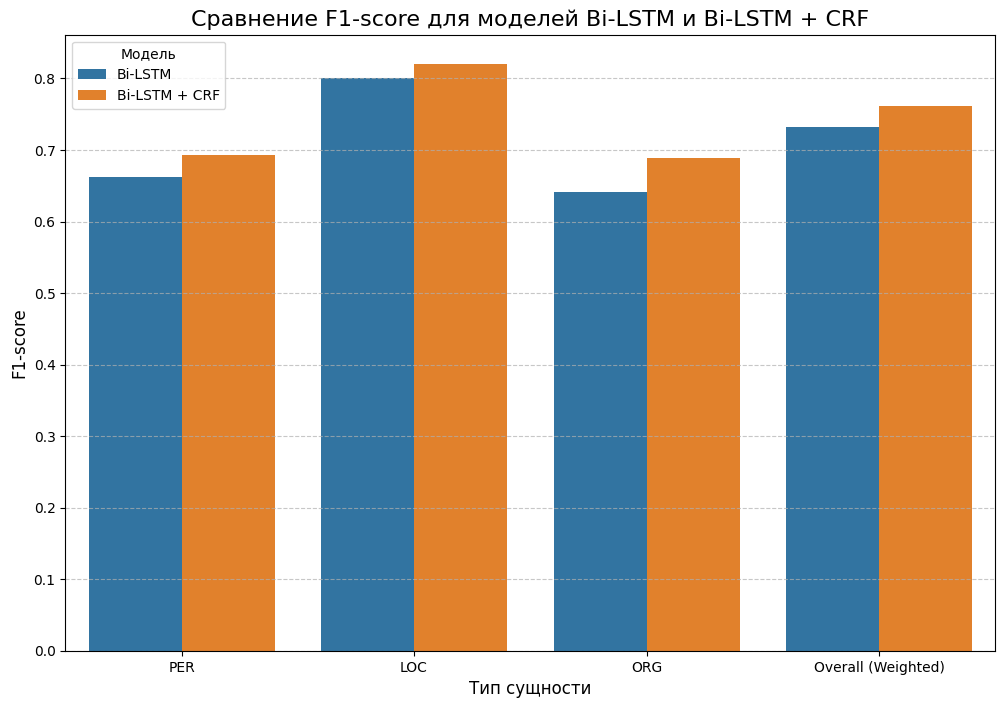

In [ ]:
comparison_data = []
for model_name, report in history.items():
    for tag in ['PER', 'LOC', 'ORG']:
        comparison_data.append({
            'Model': model_name,
            'Entity': tag,
            'F1-score': report[tag]['f1-score']
        })
    comparison_data.append({
        'Model': model_name,
        'Entity': 'Overall (Weighted)',
        'F1-score': report['weighted avg']['f1-score']
    })

df_comparison = pd.DataFrame(comparison_data)

plt.figure(figsize=(12, 8))
sns.barplot(x='Entity', y='F1-score', hue='Model', data=df_comparison)
plt.title('Сравнение F1-score для моделей Bi-LSTM и Bi-LSTM + CRF', fontsize=16)
plt.xlabel('Тип сущности', fontsize=12)
plt.ylabel('F1-score', fontsize=12)
plt.legend(title='Модель')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Модель Bi-LSTM + CRF показала наилучшие результаты. Сохраним именно её веса.

In [26]:
model_save_path = 'bilstm_crf_ner_model.pt'
torch.save(model_crf.state_dict(), model_save_path)

print(f"Веса сохранены: {model_save_path}")

Веса сохранены: bilstm_crf_ner_model.pt


Для дальнейшего улучшения качества модели можно сделать следующее:
*   **Использование предобученных эмбеддингов:** Инициализация слоя `Embedding` с помощью предобученных векторов (например, Word2Vec или fastText), обученных на больших корпусах русского языка.

*   **Применение более сложных архитектур:** Использование трансформерных моделей, которые могут показать значительно более высокое качество, но это оставим для следующих работ.